In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.40', '1.0.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas')

In [6]:
!ls

Sanskrit_Classification_Model-Slokas.ipynb  sloka_classification.csv


In [7]:
df = pd.read_csv(path/'sloka_classification.csv')
df.head()

,Sloka,Class
0,"कश्चित् कस्यचिन्मित्रं, न कश्चित् कस्यचित् रि...",Chanakya Slokas
1,मूर्खशिष्योपदेशेन दुष्टास्त्रीभरणेन च। ...,Chanakya Slokas
2,दुष्टा भार्या शठं मित्रं भृत्यश्चोत्तरदायकः। ...,Chanakya Slokas
3,धनिकः श्रोत्रियो राजा नदी वैद्यस्तु पञ्चमः। ...,Chanakya Slokas
4,जानीयात्प्रेषणेभृत्यान् बान्धवान्व्यसनाऽऽगमे। ...,Chanakya Slokas


In [8]:
df['Class'].unique()

array(['Chanakya Slokas', 'Vidur Niti Slokas', 'sanskrit-slogan'], dtype=object)

In [9]:
print('Chanakya Slokas', (df['Class'] == 'Chanakya Slokas').sum())
print('Vidur Niti Slokas', (df['Class'] == 'Vidur Niti Slokas').sum())
print('sanskrit-slogan', (df['Class'] == 'sanskrit-slogan').sum())

Chanakya Slokas 177
Vidur Niti Slokas 146
sanskrit-slogan 156


In [10]:
df['Sloka'][0]

' कश्चित् कस्यचिन्मित्रं, न कश्चित् कस्यचित् रिपु:।                        अर्थतस्तु निबध्यन्ते, मित्राणि रिपवस्तथा ॥'

In [11]:
df.shape

(479, 2)

In [13]:
df[df['Sloka'].isnull()].shape

(0, 2)

In [14]:
label_cols = list(range(1,df.shape[1]))

In [15]:
print(label_cols)

[1]


In [16]:
id_to_col = list(df.columns)

In [17]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [18]:
class SanskritTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/sanskrit_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [19]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/sanskrit_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(20000)]

In [20]:
itos

['<unk>',
 '<s>',
 '</s>',
 '▁।',
 '▁',
 'ं',
 ',',
 'ः',
 '-',
 'म्',
 'स्य',
 'े',
 '▁च',
 '▁अस्ति',
 '।',
 '.',
 '▁इति',
 'ा',
 '▁आसीत्',
 'ाः',
 '·',
 '▁अपि',
 '▁एव',
 '▁भवति',
 '▁न',
 '▁सन्ति',
 'ेन',
 'ि',
 '▁अस्य',
 'ो',
 'ी',
 'ानि',
 '▁सः',
 '▁तस्य',
 '्',
 "▁'",
 'ेषु',
 ':',
 '▁“',
 'ानां',
 '▁स्म',
 '▁अभवत्',
 '▁q',
 '▁स',
 'ाय',
 '▁�',
 '▁अत्र',
 'म',
 "'",
 '▁वर्षे',
 '▁सह',
 '▁अ',
 'X',
 '”',
 'ात्',
 '▁अतः',
 '▁अस्मिन्',
 'न',
 '▁तमे',
 '▁यत्',
 '▁तत्र',
 'ौ',
 'तः',
 'ैः',
 'क',
 '▁तदा',
 'र',
 '▁|',
 'ान्',
 '▁"',
 'श',
 '▁इदं',
 '▁तु',
 '▁सा',
 '▁जनाः',
 '▁वर्तते',
 '▁नाम',
 'या',
 '’',
 'न्',
 '▁भारतस्य',
 'ता',
 '्य',
 '"',
 '▁–',
 'त',
 '▁स्व',
 '▁तथा',
 '▁तेन',
 'ति',
 'ेण',
 '�',
 'स',
 '▁वा',
 'राज्यस्य',
 '▁आ',
 '▁ततः',
 'ल',
 'श्च',
 '▁भवन्ति',
 '▁इत्यस्य',
 '▁अयं',
 '▁यदा',
 'याः',
 '▁प्रति',
 '▁-',
 'स्',
 'त्',
 'त्वेन',
 'योः',
 '▁•',
 '▁ते',
 '▁आसन्',
 '▁‘',
 '▁यथा',
 'व',
 '▁किन्तु',
 '▁प्र',
 '▁परन्तु',
 'नगरं',
 '▁तस्मिन्',
 'य',
 '▁वि',
 '▁हि',
 '▁एत

In [21]:
# 20,000 is the vocab size that we chose in sentencepiece
sanskrit_vocab = Vocab(itos)

In [22]:
tokenizer = Tokenizer(tok_func=SanskritTokenizer, lang='sa')

In [23]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [24]:
data_lm = TextDataBunch.from_csv(path=path, csv_name='sloka_classification.csv', text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=sanskrit_vocab)

In [25]:
data_lm.save()

In [26]:
bs=48

In [27]:
data_lm = TextLMDataBunch.load(path, 'tmp', bs=bs)

In [28]:
data_lm.show_batch()

idx,text
0,▁ x x bo s ▁तद् ▁रूपं ▁यत्र ▁गुणाः ▁॥ ▁ x x bo s ▁किं ▁तया ▁क्रियते ▁ध ेन ्वा ▁या ▁न ▁दो ग् ध् रो ▁न ▁गर्भ िणी । ▁क ोऽर्थ ः ▁पुत्रेण ▁जात ेन ▁यो ▁न ▁विद्वान् न ▁भक्ति मान् ॥ ▁ x x bo s ▁नैव ▁पश्यति ▁जन्म ान्ध ः ▁काम ान् धो ▁नैव ▁पश्यति । ▁मद ोन् मत्ता ▁न ▁पश्यन्ति ▁अर्थ ी ▁दोष ं ▁न
1,bo s ▁हिंसा ब बल म साधू नां ▁राज्ञा ▁दण्ड विधि र् बल म् । ▁शु श्रु षा ▁तु ▁बलं ▁स्त्रीणां ▁क्षमा ▁गुण वतां ▁बल म् ॥ ▁ x x bo s ▁यो ▁यस्मिन् ▁कर्माणि ▁कुशल स्त ं ▁ तस् मित्र ैव ▁योज येत् ▁॥ ▁ x x bo s ▁अनुशासन ेन ▁एव ▁मनुष्यः ▁महान् ▁भवति ▁॥ ▁ x x bo s ▁अ प्रयत्न ात् ▁कार्य वि पत्ति भ र्
2,ं ▁परि से व ते । ▁ध्रुव ाणि ▁तस्य ▁नश्यन्ति ▁च ा ध्रुव ं ▁नष्ट मेव ▁तत् ▁॥ ▁ x x bo s ▁तृण ं ▁ब्रह्म विद ▁स्वर्ग ं ▁तृण ं ▁ शूर स्य ▁जीवनम् । ▁जि मा क्ष स्य ▁तृण ं ▁नारी ▁निः स्पृह स्य ▁तृण ं ▁जगत् ॥ ▁ x x bo s ▁उपाय ेन ▁हि ▁यच्छ क्य ं ▁न ▁तच्छ क्य ं ▁ पराक्रम ैः ▁॥ ▁
3,▁याति ▁विस्तार े ▁वस्तु शक्ति तः ॥ ▁ x x bo s ▁कार्य ▁पुरुष कारेण ▁लक्ष्य ं ▁सम्पद्यते ▁॥ ▁ x x bo s ▁एक ोऽपि ▁गुण वान् ▁पुत्र ो ▁निर्गुण ैश्च ▁शत ैर् वर ः । ▁एक श्चन्द्र स्त मो ▁ह न्ति ▁न ▁च ▁तारा ः ▁सहस्रशः ॥ ▁ x x bo s ▁यत् न वान् ▁सुख मेध ते ▁॥ ▁ x x bo s ▁अनर्थ कं ▁वि प्रवास
4,▁दुःखं ▁न ▁नित्यं ▁लभते ▁सुख म् ▁॥ ▁ x x bo s ▁मित्र ं ▁भु ड् क्त े ▁सं वि भ ज्य ाश्रित ेभ्यो ▁मित ं ▁ स्वपि त्य मित ं ▁कर्म ▁कृत्वा ▁। ▁ ददात् य मित्र ेष्वपि ▁याचित ः ▁सं स्त मात्म वन्त ं ▁प्र ज हत्य न र्थ ाः ▁॥ ▁ x x bo s ▁गो भिः ▁पशु भिर श्व ैश्च ▁कृष्या ▁च ▁सु समृद्ध या ।


In [29]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [49]:
# Loading the pretrained language model on sanskrit wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-sanskrit/language-model/SanskritDataset/models/second_sa_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (383 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas
x: LMTextList (383 items)
[Text ▁ x x bo s ▁माता ▁च ▁कमला ▁देवी ▁पिता ▁देव ो ▁जनार्दन ः । ▁ बान्धव ा ▁विष्णु भक्ता श्च ▁स्वदेश ो ▁भुवन त्रयम् ॥, Text ▁ x x bo s ▁न ▁ वैर मुद् दीप यति ▁प्रशान्त ं ▁न ▁दर् प मा रो ह ति ▁ना स् तमे ति ▁। ▁न ▁दुर्ग तोऽ स्म ीति ▁करो त्य कार्यं ▁तम ार्य शील ं ▁परमा हु रा र् याः ▁॥, Text ▁ x x bo s ▁काल वित् ▁कार्यं ▁साधय ेत् ▁॥, Text ▁ x x bo s ▁न ▁सं रम्भ ेण ार भ ते ▁त्रि वर्ग मा कारि तः ▁शंस ति ▁तत्त्व मेव ▁। ▁न ▁मित्र ार्थ रो च यते ▁विवाद ं ▁ना पु जित ः ▁कु प्य ति ▁च ाप्य मूढ ः ▁॥, Text ▁ x x bo s ▁अध ना ▁धन मिच्छन्त ि ▁वाच ं ▁चैव ▁चतुष् पद ाः । ▁मानवाः ▁स्वर्ग मिच्छन्त ि ▁मोक्ष मिच्छन्त ि ▁देवताः ॥]...
Path: /home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas;

Valid: LabelList
y: LMLabel (96 items)
[Category 0, Category 0, Cat

In [32]:
# Fine tuning the prtrained LM on current dataset

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


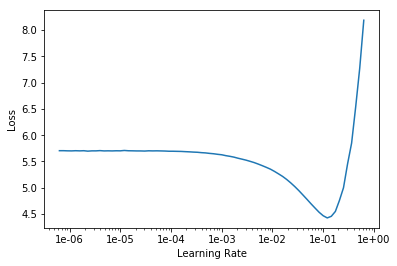

In [34]:
learn.recorder.plot()

In [50]:
learn.freeze()

In [51]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,5.715501,5.590843,0.252003


In [52]:
learn.save('fit_head', with_opt=True)

In [53]:
learn.load('fit_head', with_opt=True);

In [54]:
learn.unfreeze()

In [55]:
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,5.575705,5.571742,0.248798
2,5.582384,5.565955,0.250401
3,5.560453,5.543623,0.253606
4,5.523142,5.471897,0.258013
5,5.492814,5.426103,0.266026
6,5.449636,5.368439,0.267228
7,5.406374,5.303986,0.272837
8,5.355485,5.278626,0.276442
9,5.310457,5.230654,0.278846
10,5.268438,5.213259,0.279247


In [56]:
learn.save('fine_tuned', with_opt=True)

In [57]:
learn.load('fine_tuned', with_opt=True);

In [59]:
learn.predict('कश्चित्',n_words=10)

'कश्चित् ▁f e मुद् ▁नियमाः ▁विषयाः ▁वि ▁श्रुत्वा ▁इति ▁ ▁ननु'

In [60]:
learn.save_encoder('fine_tuned_enc')

In [61]:
data_clas = TextClasDataBunch.from_csv(path=path, csv_name='sloka_classification.csv', tokenizer=tokenizer, vocab=sanskrit_vocab, text_cols=[0], label_cols=label_cols)

In [62]:
data_clas.show_batch()

text,target
▁ x x bo s ▁षड ि मान् ▁पुरुष ो ▁जह ्य ात् ▁भिन्नं ▁नाव मिव ार्णव े ▁अप्र वक्त ार ं ▁आचार्य ं ▁अन ध्याय िन म् ▁ऋत्विज म् ▁। ▁आरक्षित ार ं ▁राजानं ▁भार्या ं ▁च ाऽ प्रिय वाद िनी ं ▁ग्राम काम ं ▁च ▁गोपाल ं ▁वन काम ं ▁च ▁न ाप ितम् ॥,Vidur Niti Slokas
▁ x x bo s ▁ना क्रोश ी ▁स्यात् राव मान ी ▁पर स्य ▁मित्र द्रोह ी ▁नो त ▁नि च ोप से वी । ▁न ▁च ाभिमान ी ▁न ▁च ▁ हीन वृत्त ो ं ▁ रु क्षा ं ▁वाच ं ▁र ुष ती ं ▁ वर्ज यी त ॥,Vidur Niti Slokas
"▁ x x bo s ▁म र्म ाण्य स्थ ी नि ▁ह्रदय ं ▁तथा सू न् ▁ , रु क्षा ▁वाच ो ▁निर् दह न्ती ह ▁पुं सा म् । ▁तस्माद् ▁वाच ुम ुष ती मु ग्र रुपा ं ▁धर्म ा राम ो ▁नित्य शो ▁ वर्ज यी त ॥",Vidur Niti Slokas
▁ x x bo s ▁न ▁वै ▁ भि त्रा ▁जातु ▁ चरन्ति ▁धर्म ं ▁न ▁वै ▁सुखं ▁प्राप्नुवन् ती ह ▁ भि त्र ाः । ▁न ▁वै ▁सुखं भि त्रा ▁गौरवं प्रा प्नुव न्ति ▁न ▁वै ▁ भि त्रा प्र श म ं रो च यन्ति ▁॥,Vidur Niti Slokas
▁ x x bo s ▁अ सन् त्याग ात् ▁पाप कृता म पाप ां स् तुल्य ो ▁दण्ड ः ▁ स्पृश ते ▁मिश्र भाव ात् । ▁शुष्क ेण ा र्द ं दह ्यते ▁मिश्र भाव ात् त स्मात् ▁पाप ैः ▁सह ▁सन्धि ▁न कुर ्य ्य ात् ▁॥,Vidur Niti Slokas


In [63]:
data_clas.sanity_check()

In [64]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)

In [65]:
learn.load_encoder('fine_tuned_enc')

In [66]:
learn.freeze()

In [67]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


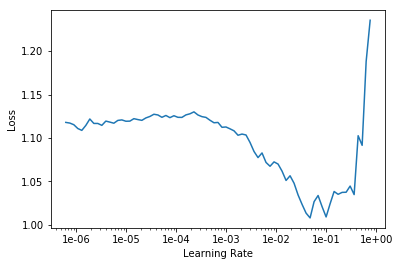

In [69]:
learn.recorder.plot()

In [70]:
learn.loss_func.func

CrossEntropyLoss()

In [71]:
kappa = KappaScore()

In [72]:
learn.metrics = [kappa, accuracy]

In [73]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,1.250536,1.061618,0.299627,0.552083


In [74]:
learn.save('first-full')

In [91]:
learn.load('first-full');

In [92]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,1.078486,1.031951,0.120116,0.406250
2,1.028705,0.927832,0.332068,0.541667
3,0.973889,0.870759,0.506030,0.666667
4,0.943297,0.870116,0.454014,0.635417
5,0.907101,0.843129,0.562856,0.708333


In [93]:
learn.save('final')

In [99]:
learn.predict(' न दुर्जन: साधुदशामुपैति बहुप्रकारैरपि शिक्ष्यमाण: । आमूलसिक्त: पयसा घृतेन न निम्बवृक्षो मधुरत्वमेति ।।')

(Category Chanakya Slokas, tensor(0), tensor([0.7284, 0.0772, 0.1944]))

In [96]:
learn.predict(" गृहाऽऽसक्तस्य नो विद्या नो दया मासंभोजिन: । द्रव्यलुब्धस्य नो सत्यं स्त्रैणस्य न पवित्रता ।।")

(Category Chanakya Slokas, tensor(0), tensor([0.3638, 0.3042, 0.3321]))

In [103]:
learn.predict("अनुबंधानपक्षेत सानुबन्धेषु कर्मसु। सम्प्रधार्य च कुर्वीत न वेगेन समाचरेत्।")

(Category Vidur Niti Slokas, tensor(1), tensor([0.2313, 0.5306, 0.2381]))

In [101]:
learn.predict("नद्वाविमौ पुरुषौ राजन स्वर्गस्योपरि तिष्ठत: । प्रभुश्च क्षमया युक्तो दरिद्रश्च प्रदानवान्।।")

(Category Vidur Niti Slokas, tensor(1), tensor([0.3721, 0.3920, 0.2359]))